# **Gravitational wave data analysis 🔭**

# Exercise 1 - Matched filter

## **PART 1**

First we need to download the data set we need.

In [1]:
import sys
!{sys.executable} -m pip install pycbc ligo-common --no-cache-dir 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 KB 71.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 48.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 118.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 KB 132.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 MB 101.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 152.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 KB 181.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
#Necessary imports
from pycbc.frame import read_frame
from pycbc.filter import highpass_fir, lowpass_fir
from pycbc.waveform import get_fd_waveform
from pycbc.psd import welch, interpolate
from pycbc.catalog import Merger
import pylab
from pycbc.types import  FrequencySeries, TimeSeries

from scipy import interpolate

import numpy as np
from pycbc import frame
import pycbc
from pycbc.filter import resample_to_delta_t, highpass
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.stats import norm 
from pycbc.detector import Detector
from scipy.interpolate import interp1d

import numpy as np



In [3]:
#First we need to download the data set we need.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
d = np.load('/content/drive/MyDrive/Colab Notebooks/GW_noisedata-2.npy') #name of the data file GW_noisedata-2.npy
dt = d[:, 0]
data_H1 = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0]) #this is to comvert data into GW timeSeries
data_L1 = pycbc.types.TimeSeries(d[:, 2], delta_t = dt[1]- dt[0]) #this is to comvert data into GW timeSeries
merger = Merger("GW170817") #We select the desired event
strain, stilde = {}, {}
strain['H1'] = resample_to_delta_t(highpass(data_H1, 15.0), 1.0/2048) #downsampling to 2048Hz
strain['L1'] = resample_to_delta_t(highpass(data_L1, 15.0), 1.0/2048)

strain['H1'] = strain['H1'].crop(4, 4)
strain['L1'] = strain['L1'].crop(4, 4)

stilde['H1'] = strain['H1'].to_frequencyseries()
stilde['L1'] = strain['L1'].to_frequencyseries()


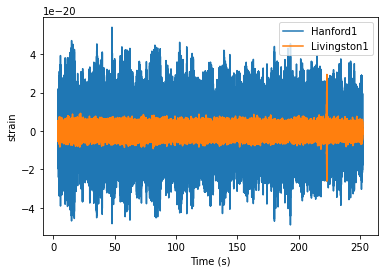

We now have a plot of the downsampled data


In [ ]:
#print (strain.delta_t)
pylab.plot(strain['H1'].sample_times, strain['H1'], label= 'Hanford1')
pylab.plot(strain['L1'].sample_times, strain['L1'], label= 'Livingston1')
pylab.legend()
pylab.xlabel('Time (s)')
pylab.ylabel('strain')
pylab.show()
print('We now have a plot of the downsampled data')

## **PART 2**

0.004032258064516129

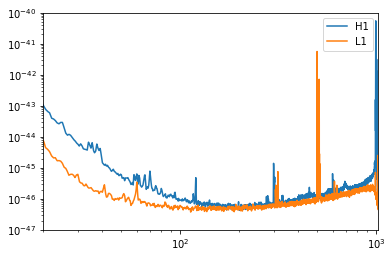

In [6]:
#Let's first plot the power spectral density ;
#Note that the data needs sphering in order for us to find the SNR

from pycbc.psd import interpolate #importing necessary module
psds = {}
for ifo in ['H1', 'L1']:

    delta_t = strain[ifo].delta_t
    seg_len = int(2 / delta_t)
    seg_stride = int(seg_len / 2)
    psds[ifo]  = pycbc.psd.welch(strain[ifo],
                      seg_len=seg_len,
                      seg_stride=seg_stride)
    
    psds[ifo] = interpolate(psds[ifo], stilde[ifo].delta_f)
    pylab.loglog(psds[ifo].sample_frequencies, psds[ifo], label=ifo)
    pylab.xlim(20, 1024)
    pylab.ylim(1e-47, 1e-40)

pylab.legend()
psds[ifo].delta_f

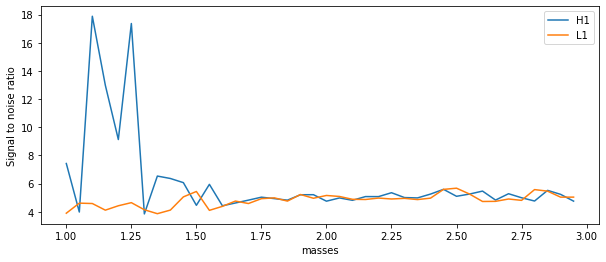

We can see that the pick is at about 1.1 Solar masses


In [7]:
#Now Let's find the SNR
#first we import more necessary modules
from numpy import arange
from pycbc.waveform import get_td_waveform
from pycbc.filter import matched_filter

snr_list = []
snrs = {}
interval = 0.05
masses = arange(1,3,interval) #we assume an equal mass binary system (m1=m2)

#We will be searching through the range of masses to find the one that fits best
for ifo in ['H1', 'L1']:
  for m in (arange(1,3,interval)):
    m = round(m,2)
    hp, hc = get_td_waveform(approximant="TaylorT2",
                            mass1=m,
                            mass2=m,
                            delta_t=strain[ifo].delta_t,
                            f_lower=15.0)
    
    #Resizing to match the data
    hp.resize(len(strain[ifo]))
    template = hp.cyclic_time_shift(hp.start_time)

    snr = matched_filter(template, strain[ifo],
                         psd=psds[ifo],
                        low_frequency_cutoff=15.0)
    
    snr1 = snr.crop(4 + 4, 4)
    snrs[ifo] = snr_list.append(max(abs(snr1)))
  snrs[ifo] = snr_list
  snr_list = []

pylab.figure(figsize=[10, 4])
pylab.plot(masses, snrs['H1'], label = 'H1')
pylab.plot(masses, snrs['L1'], label = 'L1')
pylab.legend()
pylab.ylabel('Signal to noise ratio')
pylab.xlabel('masses')
pylab.show()

print('We can see that the pick is at about 1.1 Solar masses')
#Hereunder is a plot that shows the SNR vs the total mass of the system with masses uniformely distributed

## **PART 3**

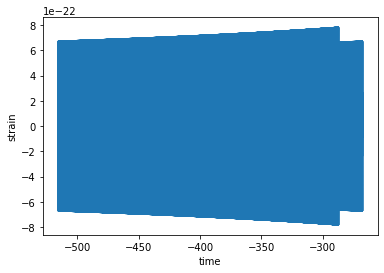

In [10]:
#For this part we assume equal masses
import numpy
nsnr = (numpy.array(snrs['H1'])**2 + numpy.array(snrs['L1'])**2)**0.5
ii = numpy.where(nsnr == max(nsnr))
ifo = 'L1'
m = masses[ii]
conditioned = strain[ifo]
hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=strain[ifo].delta_t,
                     f_lower=15.0)

# We will resize the vector to match our data
hp.resize(len(strain[ifo]))

#The waveform begins at the start of the vector, 
#so we need to shift the data in such a way, 
#that the merger is at the beginning of the data. 
template = hp.cyclic_time_shift(hp.start_time)
pylab.plot(hp.sample_times, template)
pylab.xlabel('time')
pylab.ylabel('strain')
pylab.show()

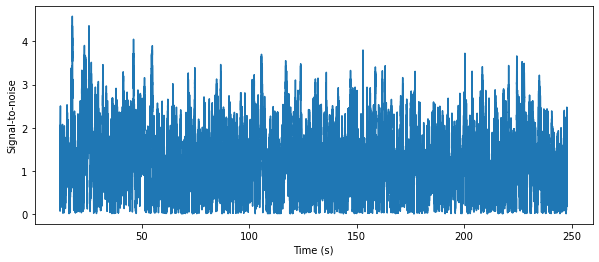

We found a signal at 17.75830078125 seconds with SNR 4.580815054951679


In [14]:
ifo = 'L1'
conditioned = strain[ifo]

snr = matched_filter(template, conditioned,
                     psd=psds[ifo], 
                     low_frequency_cutoff=15)

snr = snr.crop(4 + 4, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

#Printing SNR vs. time
print("We found a signal at {} seconds with SNR {}".format(time, abs(snrp)))

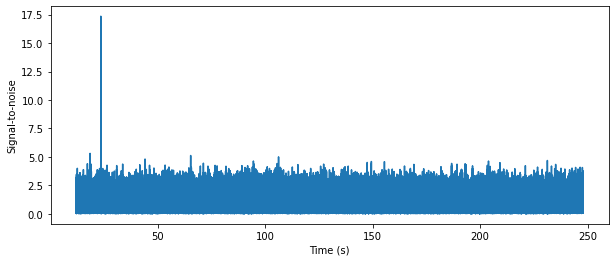

We found a signal at 23.5673828125s with SNR 17.35063664027163


In [24]:
from pycbc.filter import matched_filter
import numpy

ifo = 'L1'                            
conditioned = strain[ifo]
snr = matched_filter(template, conditioned,
                     psd=psds[ifo] , low_frequency_cutoff=20)

# Remove time corrupted by the template filter and the psd filter
# We remove 4 seonds at the beginning and end for the PSD filtering
# And we remove 4 additional seconds at the beginning to account for
# the template length (this is somewhat generous for 
# so short a template). A longer signal such as from a BNS, would 
# require much more padding at the beginning of the vector.
snr = snr.crop(4 + 4, 4)

# Why am I taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

In [16]:
# The time, amplitude, and phase of the SNR peak tell us how to align our proposed signal with the data.

# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
from pycbc.filter import sigma
aligned /= sigma(aligned, psd=psds[ifo], low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

In [27]:
# We do it this way so that we can whiten both the template and the data
white_data = (conditioned.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

tapered = aligned.highpass_fir(5, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

white_data = white_data.highpass_fir(5., 512).lowpass_fir(80, 512)
white_template = white_template.highpass_fir(5, 512).lowpass_fir(80, 512)

# Select the time around the merger
white_data = white_data.time_slice(merger.time - 2, merger.time + 1)
white_template = white_template.time_slice(merger.time - 2, merger.time +1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

ValueError: ignored

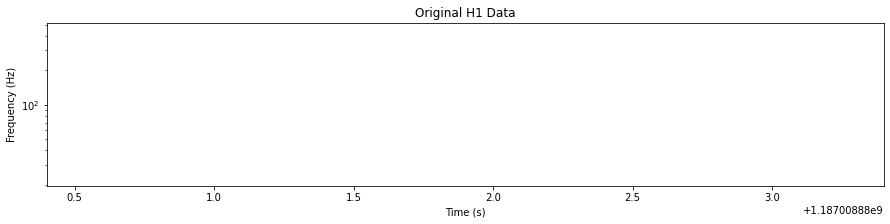

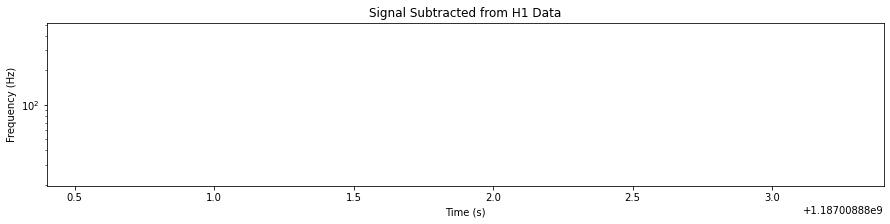

In [23]:
subtracted = conditioned - aligned

# Plot the original data and the subtracted signal data

for data, title in [(conditioned, 'Original H1 Data'),
                    (subtracted, 'Signal Subtracted from H1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001,
                                                  logfsteps=100,
                                                  qrange=(8, 8),
                                                  frange=(20, 512))
    pylab.figure(figsize=[15, 3])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    pylab.yscale('log')
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(merger.time - 2, merger.time + 1)
    pylab.show()

# Exercise 2 - Detector noise

## **PART 1**

In [33]:
#First we need to download the data set we need.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
#Importing numpy and loading the data
import numpy as np
d = np.load('/content/drive/MyDrive/Colab Notebooks/noise_ts_4096Hz.npy') #name of the data file noise_ts_4096Hz.npy
import pycbc.types 
dt = d[:, 0]
d = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0])
data = d

#Calculating power spectral density from the data
from pycbc.psd import welch, interpolate

#Interpolating the PSD to needed frequency
psds = interpolate(welch(d), 1.0 / d.duration)

Maximum SNR: 6.545257049876914. No gravitational wave detected.


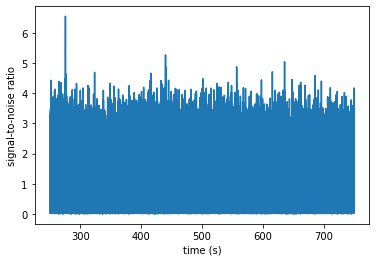

In [36]:
import pycbc.noise
import pycbc.psd
import pycbc.filter
import pycbc.waveform
import pylab

flow = 30 #Hz
stilde = data.to_frequencyseries()

interval = 0.05
masses = arange(5,10,interval)
maxSNR = 0
pltSNR = 0
maxhp = 0

for m in masses:
  hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
                              mass1=m, mass2=m,
                              f_lower=flow, delta_f=stilde.delta_f)
  hp.resize(len(stilde))
  snr = pycbc.filter.matched_filter(hp, stilde, psd=psds,
                                        low_frequency_cutoff=flow)


  # Remove regions corrupted by filter wraparound
  snr = snr[len(snr) // 4: len(snr) * 3 // 4]
 
  if max(abs(snr)) > maxSNR:
    maxSNR = max(abs(snr))
    pltSNR = snr
    maxhp = hp


if maxSNR < 8: 
  print("Maximum SNR: {}. No gravitational wave detected.".format(maxSNR))
else:
  print("Maximum SNR: {}. Gravitational wave detected.".format(maxSNR))

pylab.plot(pltSNR.sample_times, abs(pltSNR))
pylab.ylabel('signal-to-noise ratio')
pylab.xlabel('time (s)')
pylab.show()

## **PART 2**

In [37]:
#Whitening the data
#We do it this way so that we can whiten both the template and the data
white_data = (data.to_frequencyseries() / psds**0.5).to_timeseries()
white_data = white_data.crop(4,4)

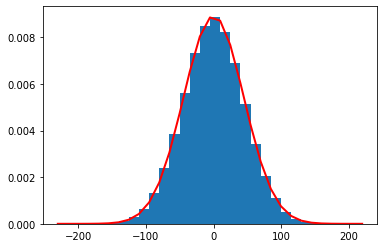

In [38]:
import matplotlib.pyplot as plt
from statistics import mean, stdev
 
mu, sigma, shape = mean(white_data), stdev(white_data), white_data.shape[0] # mean, standard deviation, shape
s = np.random.normal(mu, sigma, shape)

count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins,
         1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), 
         linewidth=2, color='r')
plt.show()

In [39]:
from pycbc.waveform import get_fd_waveform

#Generating waveforms for comparison
hp, hc = get_fd_waveform(approximant="TaylorF2",
                         mass1=3,
                         mass2=3,
                         delta_f=1.0/(200.0),
                         distance = 500,
                         f_lower=20.0,
                         f_final = 2048.0) #Luminosity distance = 500 Mpc

In [40]:
from pycbc.filter import sigmasq

intervals = 1000
data_slice = int(len(data)/intervals)
SNRlist = []

for i in range(0, intervals):

  data_chunk = data[i * data_slice: (i+1)*data_slice]
  psd = interpolate(welch(data_chunk), 1.0 / d.duration)
  psds = pycbc.psd.interpolate(pycbc.psd.welch(data_chunk), hp.delta_f)
  SNR = (pycbc.filter.sigmasq(hp, psds))**0.5
  SNRlist.append(SNR)

## **PART 3**

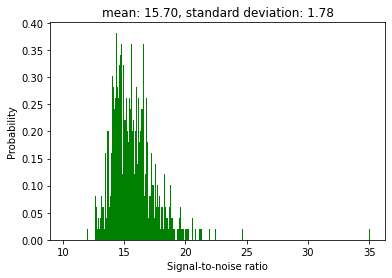

In [42]:
import matplotlib.pyplot as plt
from statistics import mean, stdev
from scipy.stats import norm

# Let's plot the histogram
plt.hist(SNRlist, bins = 500, color = "green", density=True)

# Plotting Best Fit
mu, sigma = mean(SNRlist), stdev(SNRlist)
y = norm.pdf(25, mu, sigma)
plt.plot(25, y)

plt.title('mean: {:.2f}, standard deviation: {:.2f}'.format(mu, sigma))
plt.xlabel("Signal-to-noise ratio")
plt.ylabel("Probability")

#Now we print the plot
plt.show()

#With this plot we have proved that the noise doesn't follow the stationary Gaussian distribution

# Exercise 3 - 

## **Part 1**

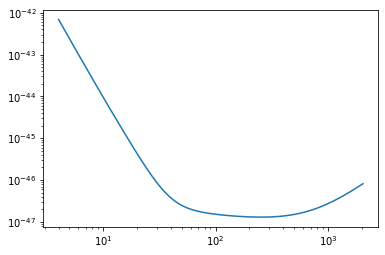

In [43]:
import pycbc.psd
import numpy as np

flow = 4.0
delta_f = 1.0 / 16
flen = int(2048.0/ (delta_f)) + 1

psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

psd.data[:int(flow/delta_f)] = np.inf #set the value outside the frequency range to infinity
psd.data[-1] = np.inf

pylab.loglog(psd.sample_frequencies, psd)
pylab.show()

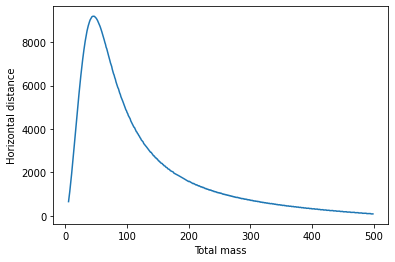

In [47]:
from pycbc.filter import sigmasq
flow = 4.0

interval = 1
masses = arange(5,500,interval)

a = []
b = []

from pycbc import waveform

for m in masses:
  hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
                              mass1=m, mass2=m,
                              f_lower=flow, 
                              delta_f=delta_f,
                              distance = 100)

  SNR = (pycbc.filter.sigmasq(hp, psd))*0.5

  if SNR > 8: 
    a.append(SNR/8)
    b.append(m)

pylab.plot(b, a)
pylab.ylabel('Horizontal distance')
pylab.xlabel('Total mass')
pylab.show()

<ipython-input-49-db1e8aade0eb>:16: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  pylab.xlim(min(psd.sample_frequencies), max(psd.sample_frequencies))


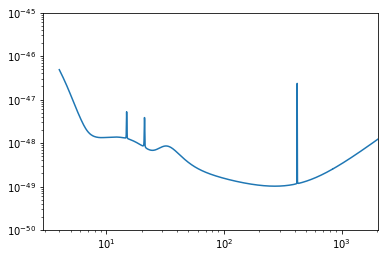

In [49]:
import pycbc.psd
import numpy as np

flow = 4.0 # set up the lower cut off frequency
delta_f = 1.0 / 16
flen = int(2048.0/ (delta_f)) + 1

psd = pycbc.psd.EinsteinTelescopeP1600143(flen, delta_f, flow)

psd.data[:int(flow/delta_f)] = np.inf #set the value outside the frequency range to infinity
psd.data[-1] = np.inf

# print(psd.sample_frequencies)

pylab.loglog(psd.sample_frequencies, psd)
pylab.xlim(min(psd.sample_frequencies), max(psd.sample_frequencies))
pylab.ylim(1e-50, 1e-45)
pylab.show()

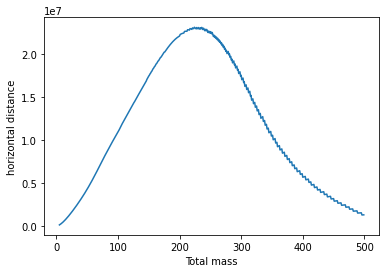

In [50]:
from pycbc.filter import sigmasq
flow = 4.0 #Hz

interval = 1
masses = arange(5,500,interval)

a = []
b = []

for m in masses:
  hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
                              mass1=m, mass2=m,
                              f_lower=flow, 
                              delta_f=delta_f,
                              distance = 100)

  SNR = (pycbc.filter.sigmasq(hp, psd))*0.5

  if SNR > 8: 
    a.append(SNR/8)
    b.append(m)

pylab.plot(b, a)
pylab.ylabel('horizontal distance')
pylab.xlabel('Total mass')
pylab.show()